# Approximation in Fourier and Wavelet spaces


This notebook reviews some application of approximation in wavelets and fourier analysis. 

We will look at
* Signal approximation with Haar wavelet analysis (denoising, compression)
* Image compression via discrete cosine transform
* Image approximation from Haar (and more general) wavelets. 

Let us start with the basic useful packages as usual


In [1]:
import numpy as np
# Contains the Fourier transforms
from numpy.fft import fft, fftfreq, fftshift
# Plotting things inside the notebook
import pylab as pyl
import matplotlib.pyplot as plt
%matplotlib inline 

import pywt


# Homemade functions for Waves2020
# import utils_fct as utlW # For "utils waves" whilst avoiding pollution of the namespace

Before we start, let us include some important functions which we may need down the road. Read them to understand what is happening in them. 

In [23]:
from scipy.ndimage import gaussian_filter

def load_image(fname, do_grayscale = True): 
    img = plt.imread(fname)
    if do_grayscale:
        if len(img.shape) > 2: 
            img = np.sum(img, axis=2)/img.shape[2]
        
    I_min = img.min()
    I_max = img.max()
    
    if I_min == I_max: 
        output_img = I_max-I_min
    else: 
        output_img = (img-I_min)/I_max-I_min
    
    return output_img
    
def add_gaussian_blurring(in_img, filter_size = 5): 

    result = gaussian_filter(in_img, sigma=filter_size)
    
    return result

def add_random_noise(l, std_val = None): 
    if std_val is None: 
        std_val = l.std
    return l + 0.4 * std_valal * np.random.random(l.shape)

def DFT(x):
    """
    Compute the discrete Fourier Transform of the 1D array x
    :param x: (array)
    """

    N = x.size
    n = np.arange(N)
    k = n.reshape((N, 1))
    e = np.exp(-2j * np.pi * k * n / N)
    return np.dot(e, x)
    
def create_dft_mtx(N_dim, sqrt_normalisation = False): 
    i, j = np.meshgrid(np.arange(N_dim), np.arange(N_dim))
    omega_N = np.exp(-2*np.pi*1j / N_dim)
    dft_mtx = np.power(omega_N, i*j)
    if sqrt_normalisation: 
        dft_mtx = dft_mtx/np.sqrt(N_dim)
    
    return dft_mtx
    
def dft1D_from_mtx(in_signal, dft_mtx = None, sqrt_normalisation = False, do_inverse = False): 
    '''
    This function computes the DFT using the matrix vector multiplication and
    Returns both the fourier transformed vector and the DFT matrix 
    Note that this is not normalised
     
    sqrt_normalisation is useless in case the dft_mtx has been passed. 
    '''
    if dft_mtx is None:
        N_dim = in_signal.size
        dft_mtx = create_dft_mtx(N_dim, sqrt_normalisation)
    
    return dft_mtx.dot(in_signal), dft_mtx
    
def dft2d_from_mtx(in_signal, dft_mtx): 
    return dft_mtx.dot(in_signal).dot(dft_mtx.T)

## Haar signal processing

Before we start, we need to implement a Haar wavelet analysis and synthesis algorithm. We will do this by implementing the Haar transform directly in the signal domain. 

We are getting a finite dimensional signal which we will assume to be of size $N = 2^n$ for simplicity

Remembering the sequence diagram for the Haar transform (filtering followed by downsampling), this is straightforward. 
We will directly implement the reconstruction in the same way while we're at it. 

In [3]:
def oneLvlHaarDecomposition(inputSignal, normalized = False): 
    """Let's assume this is a 2^n sized signal for simplicity. We will not make any software implementation effort to validate this"""
    N = np.size(inputSignal)
    outputalpha = np.zeros(int(N/2)) # The lower level approximation coefficient
    outputbeta = np.zeros(int(N/2)) # The lower level wavelet details
    
    for idx in range(int(N/2)): 
        outputalpha[idx] = (inputSignal[2*idx] + inputSignal[2*idx-1])/2
        outputbeta[idx] = (inputSignal[2*idx] - inputSignal[2*idx-1])/2
        
    return outputalpha, outputbeta

def oneLvlHaarReconstruction(inputApprox, inputDetails, normalized = False): 
    N = size(inputApprox) # This should be the same as size(inputDetails) 
    outputAlpha = np.zeros(2*N)
    # Could be written as 
    # outputAlpha = np.array([inputApprox[idx // 2] + (-1)^(idx % 2) inputDetails[idx // 2] for idx in range(2*N)])
    for idx in range(2*N): 
        outputAlpha[idx] = inputApprox[idx // 2] + (-1)^(idx % 2) * inputDetails[idx // 2] 
        # Note that here // represent the integer division and % the modulo operation
        
    return outputAlpha


Let's start with a simple constant function and see if we indeed get what we were expecting! 


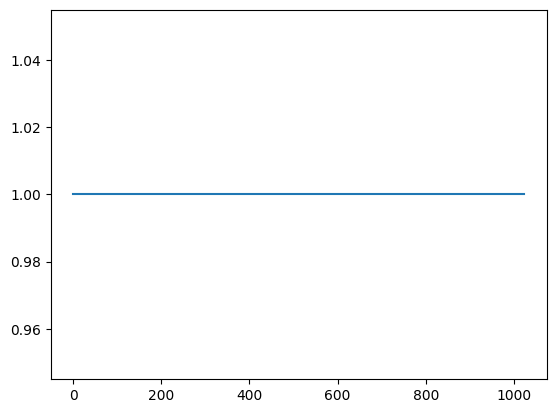

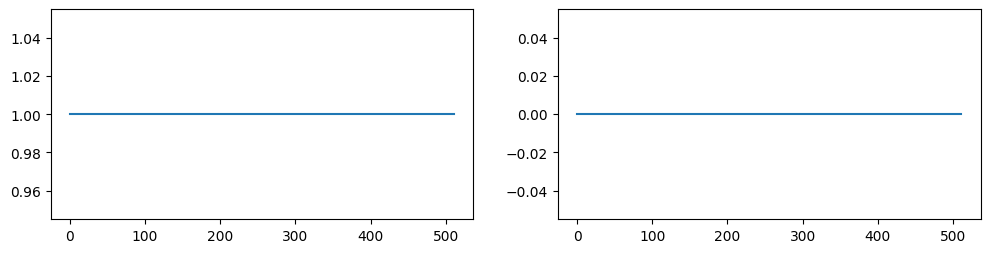

In [4]:
N = 2**10
cst_signal = np.ones(N)

# Let's plot this signal
fig = plt.figure()
plt.plot(cst_signal)

alpha_cst, beta_cst = oneLvlHaarDecomposition(cst_signal)

fig = plt.figure(figsize=(12,6), dpi= 100, facecolor='w', edgecolor='k')
ax1 = fig.add_subplot(221)  
ax2 = fig.add_subplot(222)  
ax1.plot(alpha_cst)
ax2.plot(beta_cst)

And let us look now at a simple step function. What should we expect? 

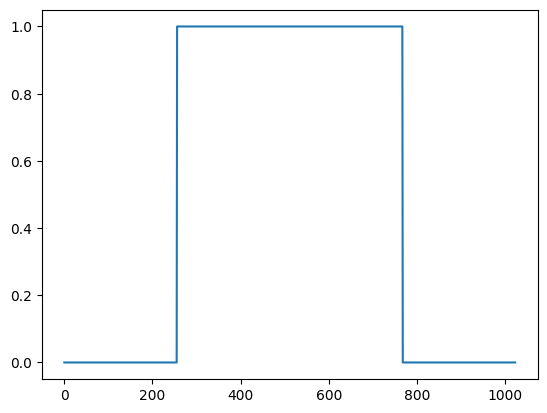

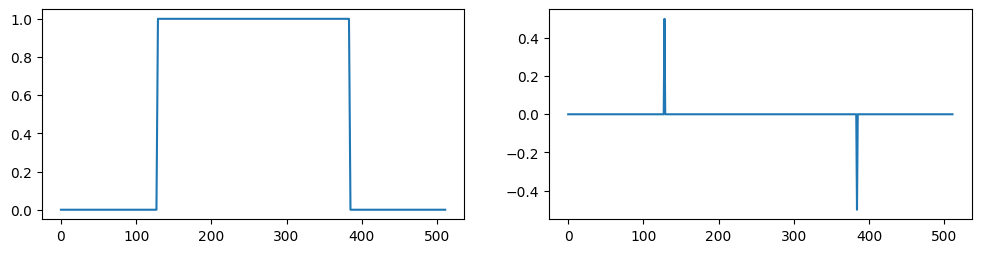

In [5]:
step_fct = np.zeros(N)
step_fct[int(N/4):int(3*N/4)] = 1

fig = plt.figure()
plt.plot(step_fct)

alpha_step, beta_step = oneLvlHaarDecomposition(step_fct)

fig = plt.figure(figsize=(12,6), dpi= 100, facecolor='w', edgecolor='k')
ax1 = fig.add_subplot(221)  
ax2 = fig.add_subplot(222)  
ax1.plot(alpha_step)
ax2.plot(beta_step)

What if now we have a slow slope? What should be expected from the wavelete approximation and detail coefficients? 


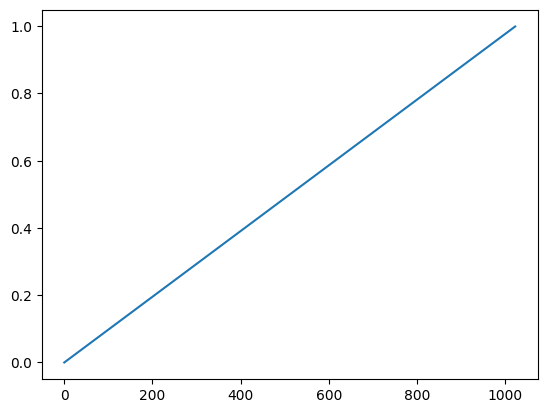

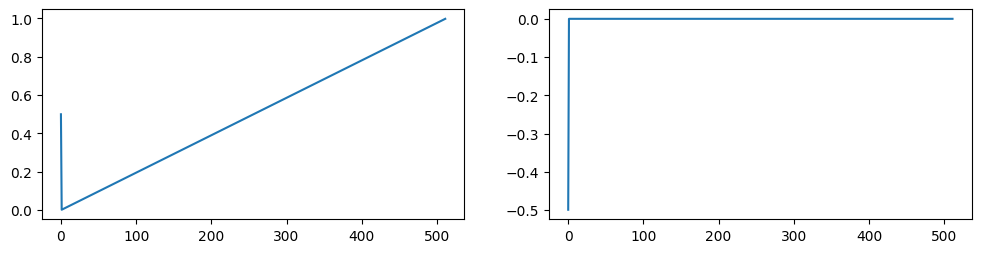

In [6]:
slope_up = np.arange(0,N)/N

alpha_slope, beta_slope = oneLvlHaarDecomposition(slope_up)

fig = plt.figure()
plt.plot(slope_up)

fig = plt.figure(figsize=(12,6), dpi= 100, facecolor='w', edgecolor='k')
ax1 = fig.add_subplot(221)  
ax2 = fig.add_subplot(222)  
ax1.plot(alpha_slope)
ax2.plot(beta_slope)

And now, let us look at a proper saw tooth signal

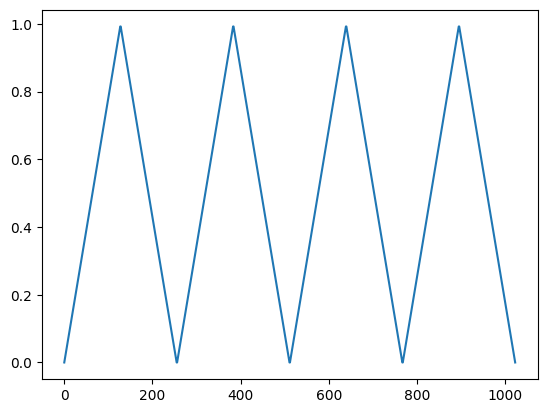

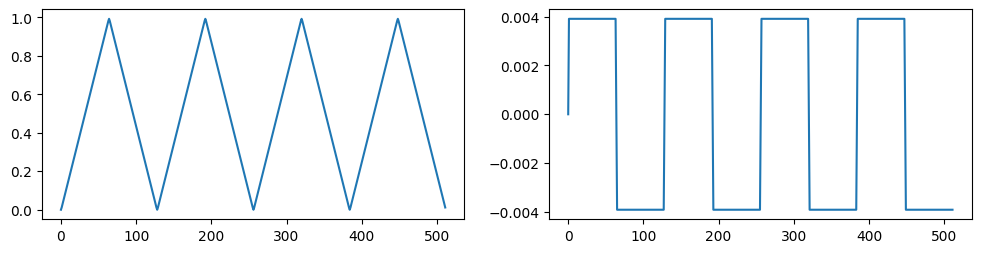

In [7]:
len_base = 7
base_signal = np.arange(0,2**len_base)/(2**len_base)
saw_tooth = np.zeros(N)
for i in range(2**(10-len_base)): 
    saw_tooth[i*2**len_base:(i+1)*2**len_base] = ((i % 2) == 0)*base_signal + ((i % 2) == 1)*base_signal[::-1]


alpha_saw, beta_saw = oneLvlHaarDecomposition(saw_tooth)

fig = plt.figure()
plt.plot(saw_tooth)

fig = plt.figure(figsize=(12,6), dpi= 100, facecolor='w', edgecolor='k')
ax1 = fig.add_subplot(221)  
ax2 = fig.add_subplot(222)  
ax1.plot(alpha_saw)
ax2.plot(beta_saw)

We have so far applied only one level of approximation / detail decomposition. Let us look at what happens on a _complete_ Haar wavelet decomposition. 

In [8]:
def Haar_decomposition(input_sig, nb_level = None): 
    '''This function expects input_sig to have a length as a power of 2. It will crash if we don't do this.'''
    sig_length = len(input_sig)
    nb_max_lvl = int(np.log2(sig_length)) # This is the part why it is important to have a power of 2 :) 
    if nb_level is None or nb_level > nb_max_lvl: 
        nb_level = nb_max_lvl
    
    alphas = []
    betas = []
    
    for aLvl in range(nb_level): 
        if aLvl == 0: 
            curAlphas,curBetas = oneLvlHaarDecomposition(input_sig)
        else: 
            curAlphas,curBetas = oneLvlHaarDecomposition(alphas[aLvl-1])
        alphas.append(curAlphas)
        betas.append(curBetas)
        
    return alphas, betas

alphas, betas = Haar_decomposition(saw_tooth)

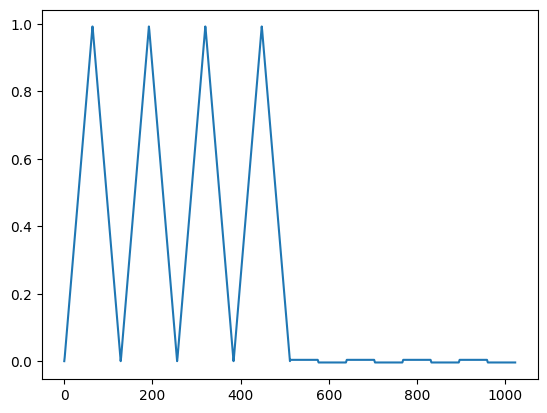

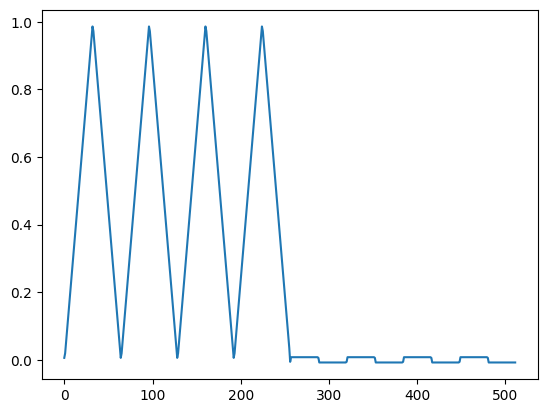

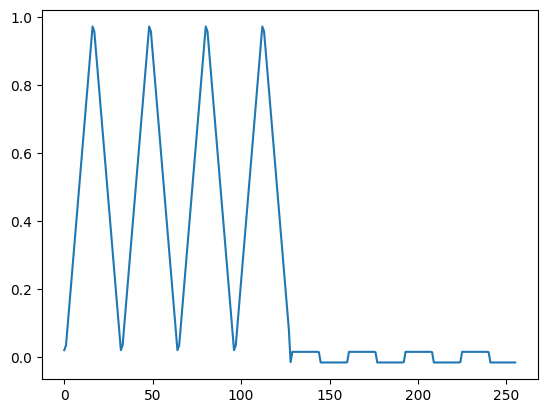

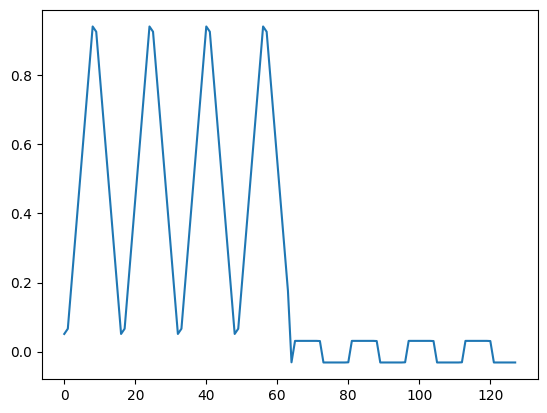

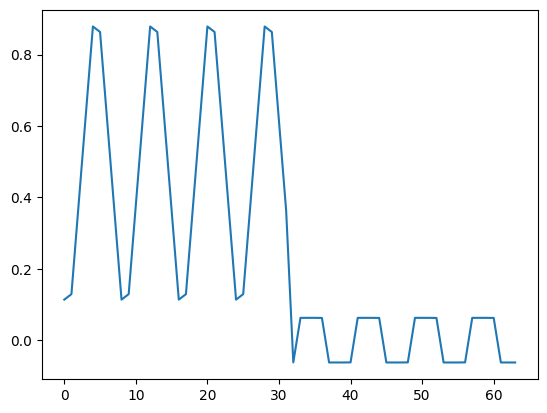

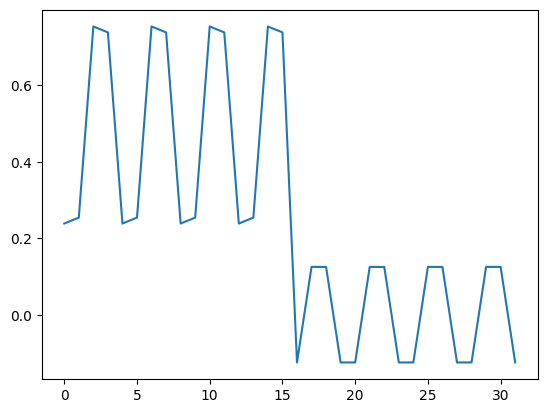

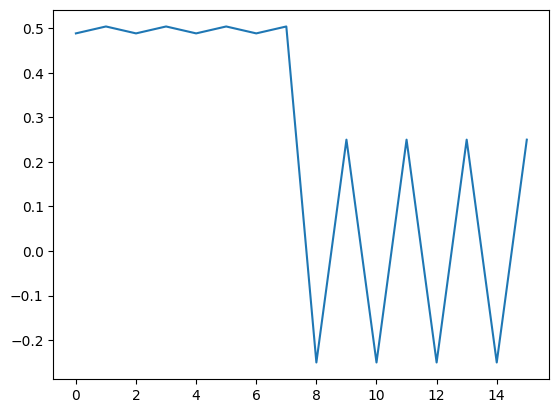

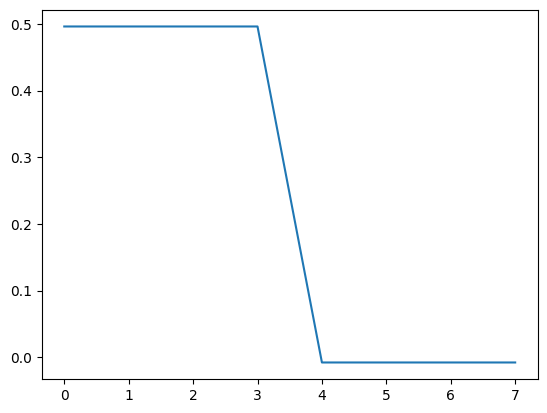

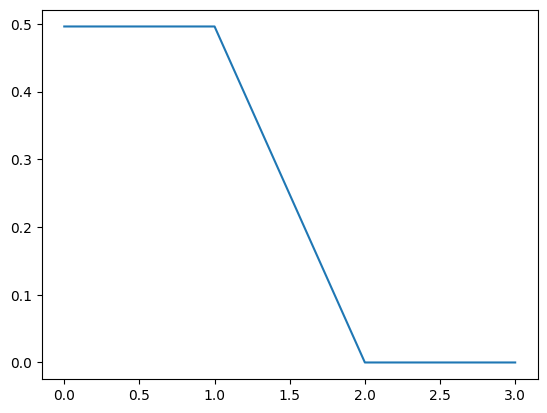

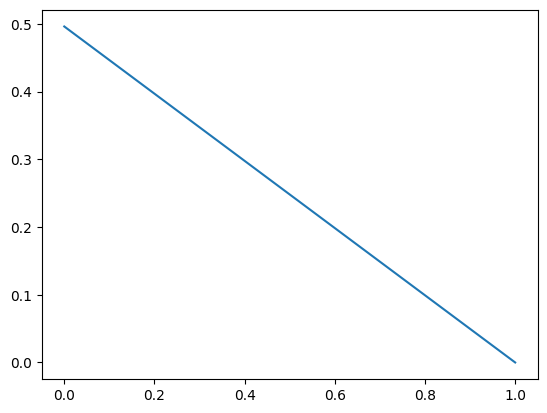

In [9]:
nb_lvl = len(alphas)
for aLvl in range(nb_lvl): 
    fig = plt.figure()
    plt.plot(np.hstack((alphas[aLvl], betas[aLvl])))

Let's have a look at a general signal with various frequency components. 

Let's us first consider a signal containing a sequence of steps. Expressed in discrete form, we have 
$$
s(i) = 
\left\{
\begin{array}{ll}
1, & \text{ if } \lfloor \log_2(i) \rfloor \text{is odd} \\ 
0, & \text{ otherwise.}
\end{array}
\right.
$$


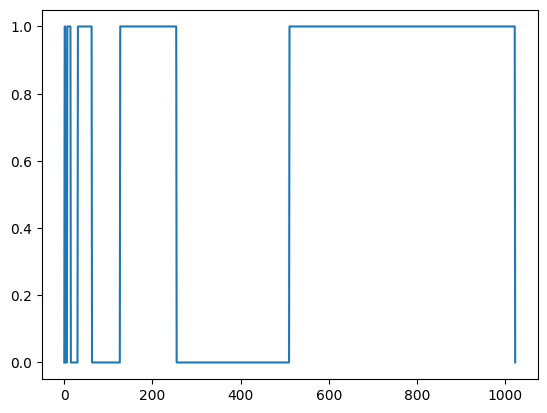

In [10]:
s = np.array([np.floor(np.log2(blah)) % 2 for blah in range(1,N+1)])
fig = plt.figure()
plt.plot(s)

In [11]:
alphas, betas = Haar_decomposition(s)

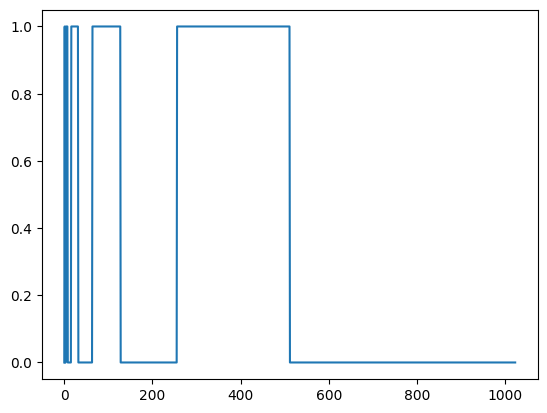

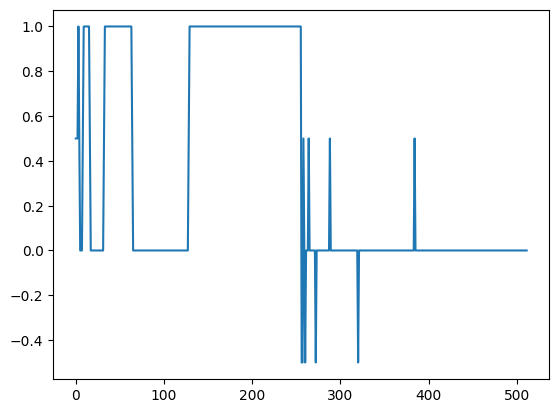

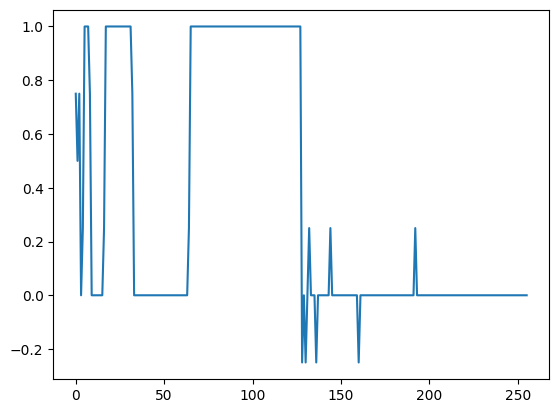

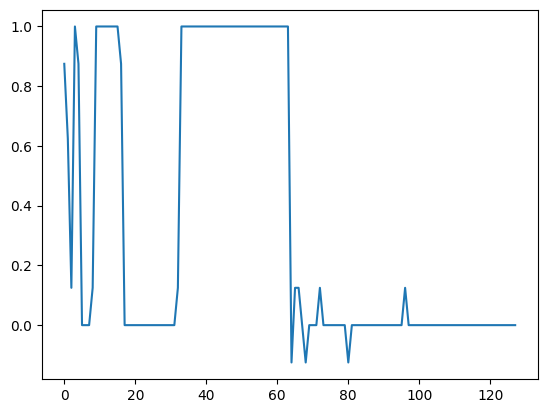

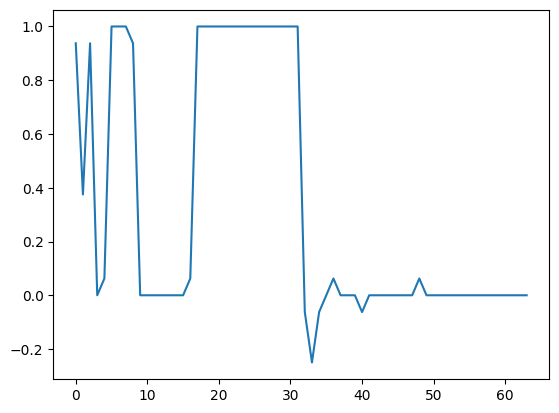

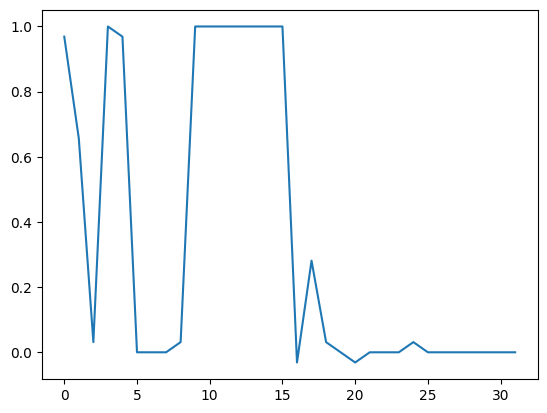

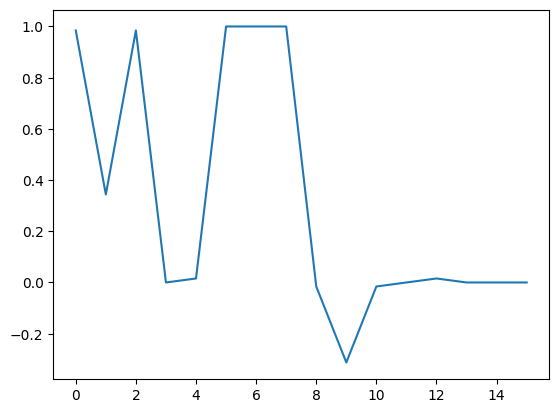

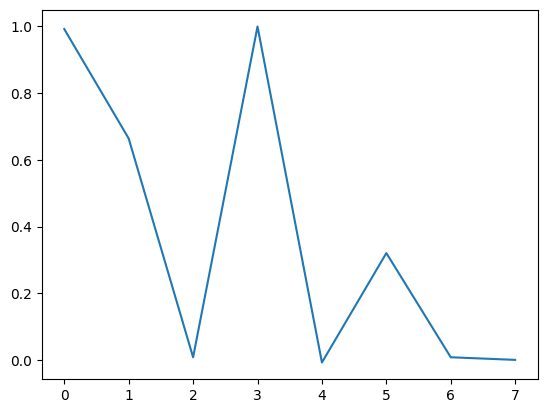

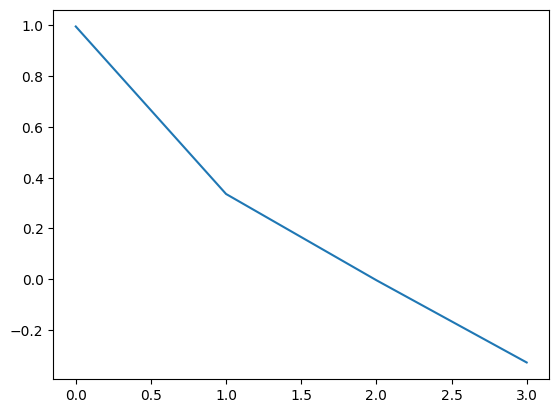

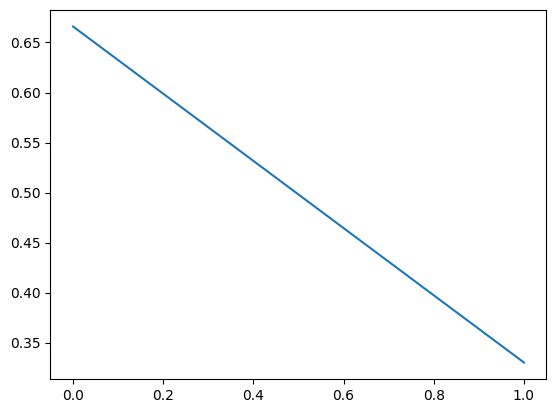

In [12]:
nb_lvl = len(alphas)
for aLvl in range(nb_lvl): 
    fig = plt.figure()
    plt.plot(np.hstack((alphas[aLvl], betas[aLvl])))

Let's look now at some pre-implemented toolboxes (and not reinvent the wheel all the time!) 
We will use pywt: PYthon Wavelet Toolbox. 

Let us first look at out to use it and see on a small 1D example how it works. 

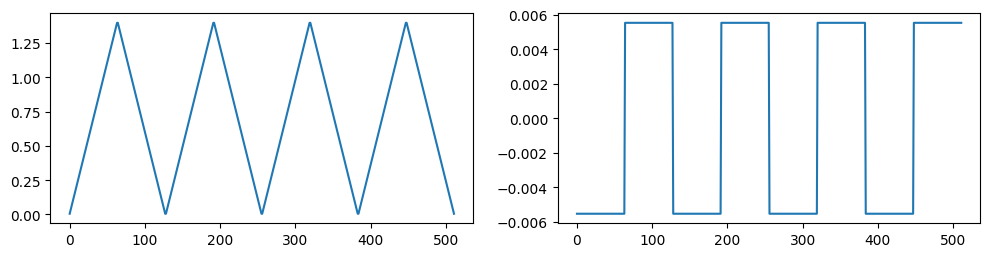

In [13]:
cA, cD = pywt.dwt(saw_tooth, 'db1') # cA stands for coefficient Approximation while cD is for Details

fig = plt.figure(figsize=(12,6), dpi= 100, facecolor='w', edgecolor='k')
ax1 = fig.add_subplot(221)  
ax2 = fig.add_subplot(222)  
ax1.plot(cA)
ax2.plot(cD)

Let us now look at the case of 2D wavelets together with a premade package

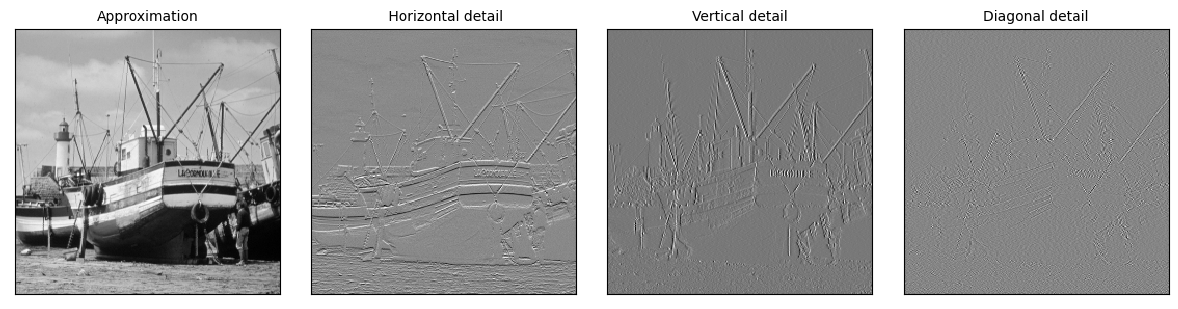

In [15]:
img_fname = "boat.bmp"
boat_img = load_image(img_fname)

titles = ['Approximation', ' Horizontal detail',
          'Vertical detail', 'Diagonal detail']
coeffs2 = pywt.dwt2(boat_img, 'db1')
# coeffs2 = pywt.dwt2(boat_img, 'bior1.3')
LL, (LH, HL, HH) = coeffs2
fig = plt.figure(figsize=(12, 3))
for i, a in enumerate([LL, LH, HL, HH]):
    ax = fig.add_subplot(1, 4, i + 1)
    ax.imshow(a, interpolation="nearest", cmap=plt.cm.gray)
    ax.set_title(titles[i], fontsize=10)
    ax.set_xticks([])
    ax.set_yticks([])

fig.tight_layout()
plt.show()

What happens now if we use different Daubechies wavelets (with higher regularities)

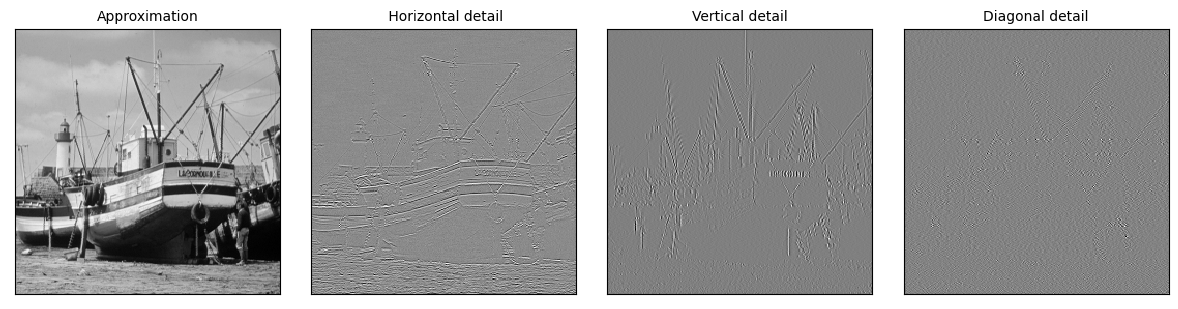

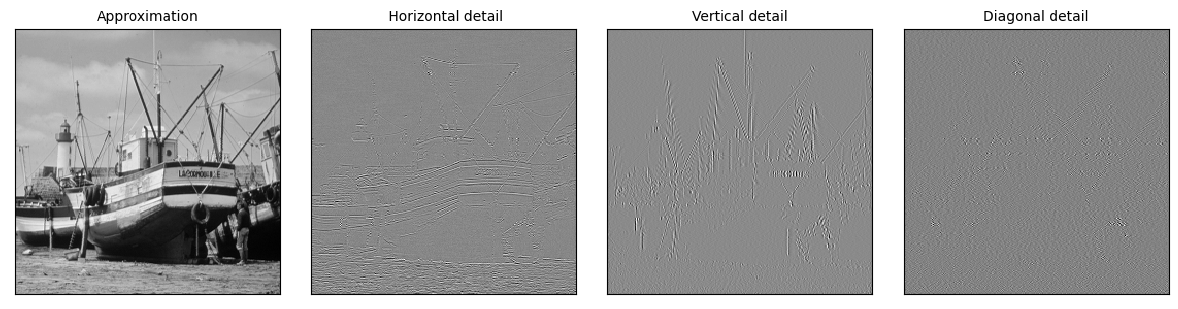

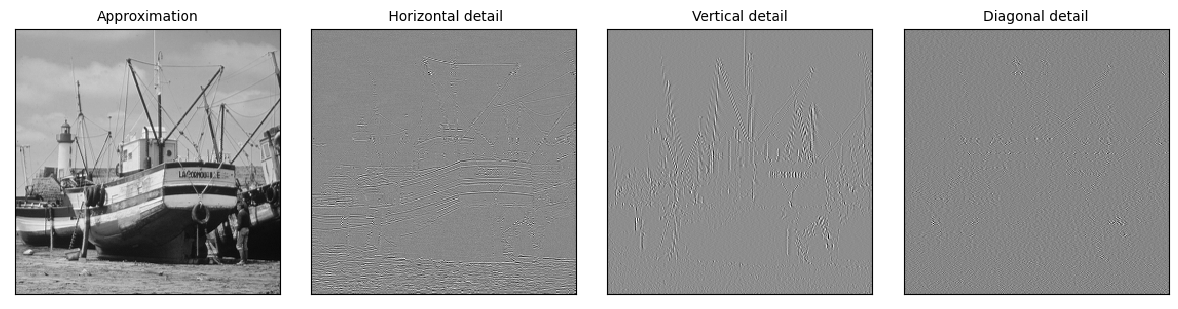

In [16]:
titles = ['Approximation', ' Horizontal detail',
          'Vertical detail', 'Diagonal detail']
coeffs2 = pywt.dwt2(boat_img, 'db2')
LL, (LH, HL, HH) = coeffs2
fig = plt.figure(figsize=(12, 3))
for i, a in enumerate([LL, LH, HL, HH]):
    ax = fig.add_subplot(1, 4, i + 1)
    ax.imshow(a, interpolation="nearest", cmap=plt.cm.gray)
    ax.set_title(titles[i], fontsize=10)
    ax.set_xticks([])
    ax.set_yticks([])

fig.tight_layout()
plt.show()

titles = ['Approximation', ' Horizontal detail',
          'Vertical detail', 'Diagonal detail']
coeffs2 = pywt.dwt2(boat_img, 'db3')
LL, (LH, HL, HH) = coeffs2
fig = plt.figure(figsize=(12, 3))
for i, a in enumerate([LL, LH, HL, HH]):
    ax = fig.add_subplot(1, 4, i + 1)
    ax.imshow(a, interpolation="nearest", cmap=plt.cm.gray)
    ax.set_title(titles[i], fontsize=10)
    ax.set_xticks([])
    ax.set_yticks([])

fig.tight_layout()
plt.show()

titles = ['Approximation', ' Horizontal detail',
          'Vertical detail', 'Diagonal detail']
coeffs2 = pywt.dwt2(boat_img, 'db4')
LL, (LH, HL, HH) = coeffs2
fig = plt.figure(figsize=(12, 3))
for i, a in enumerate([LL, LH, HL, HH]):
    ax = fig.add_subplot(1, 4, i + 1)
    ax.imshow(a, interpolation="nearest", cmap=plt.cm.gray)
    ax.set_title(titles[i], fontsize=10)
    ax.set_xticks([])
    ax.set_yticks([])

fig.tight_layout()
plt.show()

We are now looking at three approximation results: the linear approximation in which only the $N$ first coefficients are kept, the Soft thresholding denoising, and the Hard thresholding denoising. The Hard thresholding will be used in two variants: one which selects the $N$ largest entries and one which will simply cut the small entries. 

We will create artifical examples by using a known image (that of a boat for instance), and corrupting it with some Gaussian iid noise. 
We then apply the various denoising algorithms on the wavelet coefficients of the perturbered image before using the wavelet synthesis operation. 



In [ ]:
boat_shape = boat_img.shape


We now define the three wavelet based denoising operations: 

In [17]:
def linearApprox(input_img, nb_elements): 
    denoised_img = [np.zeros(np.shape(input_img[0]))]
    for a_level in input_img[1:]: 
        cur_level = []
        for a_wavelet_coef in a_level: 
            cur_level.append(np.zeros(np.shape(a_wavelet_coef)))
        denoised_img.append(cur_level)
        
    nb_coefs_left = nb_elements
    if nb_coefs_left < np.size(input_img[0]): 
        # We select only a subset of them THIS NEEDS TO BE CHANGED!
        left_per_wave = np.ceil(nb_coefs_left/3)
        for idx, a_wave in enumerate(input_img[0]): 
            denoised_img[0][idx][0:left_per_wave] = a_wave[0:left_per_wave]
            nb_coefs_left -= left_per_wave
    else: 
        # we can add all! 
        denoised_img[0] = input_img[0]
        nb_coefs_left -= np.size(input_img[0])

    cur_level = 1
    while nb_coefs_left > 0 : 
        if nb_coefs_left >= np.size(input_img[cur_level][0])*3: 
            # We can put all of them! 
            for idx, a_wave in enumerate(input_img[cur_level]): 
                denoised_img[cur_level][idx] = a_wave
                nb_coefs_left -= np.size(a_wave)
            cur_level += 1
        else: 
            # Need to deal with this another way! 
            current_idx = 0
            while nb_coefs_left > 0: 
                denoised_img[cur_level][0][current_idx,:] = input_img[cur_level][0][current_idx,:] # Horizontal wavelet
                denoised_img[cur_level][1][:,current_idx] = input_img[cur_level][1][:,current_idx] # Vertical wavelet
                denoised_img[cur_level][2][current_idx,0:current_idx] = input_img[cur_level][2][current_idx,0:current_idx]
                denoised_img[cur_level][2][0:current_idx-1,current_idx] = input_img[cur_level][2][0:current_idx-1,current_idx]
                nb_coefs_left -= (np.size(input_img[cur_level][0][current_idx,:]) + np.size(input_img[cur_level][1][:,current_idx]) + np.size(input_img[cur_level][2][current_idx,0:current_idx]) + np.size(input_img[cur_level][2][0:current_idx-1,current_idx]))
                
    return denoised_img

TODO: 

Change the parameters for wavelet type and/or extension type to visualize the impact!

In [19]:
wavelet_type = 'db2'
ext_type = 'sym'
wave_boat = pywt.wavedec2(boat_img, wavelet_type, ext_type)

In [21]:
denoised_boat_lin = linearApprox(wave_boat,int(np.size(boat_img)/8))

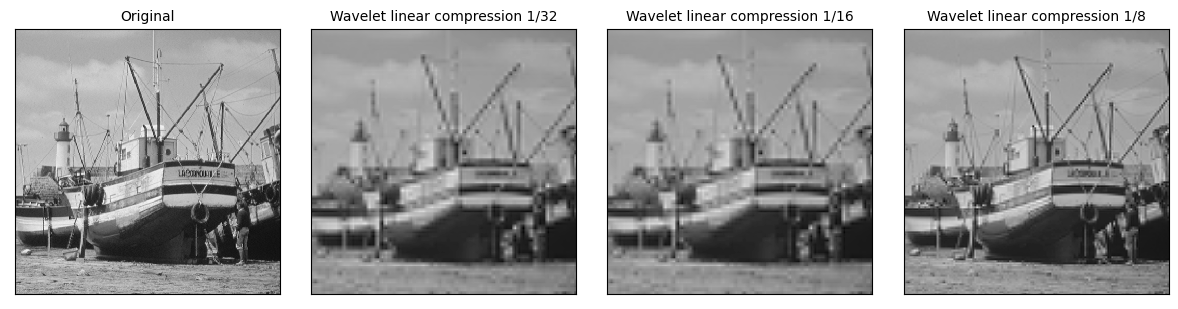

In [22]:
ratios = [32,16,8]

titles = ['Original', 'Wavelet linear compression 1/'] 
fig = plt.figure(figsize=(12, 3))
ax = fig.add_subplot(1, 4, 1)
ax.imshow(boat_img, interpolation="nearest", cmap=plt.cm.gray)
ax.set_title(titles[0], fontsize=10)
ax.set_xticks([])
ax.set_yticks([])
for i, a in enumerate(ratios):
    ax = fig.add_subplot(1, 4, i + 2)
    ax.imshow(pywt.waverec2(linearApprox(wave_boat,int(np.size(boat_img)/ratios[i])), 'db2'), interpolation="nearest", cmap=plt.cm.gray)
    ax.set_title(titles[1]+str(ratios[i]), fontsize=10)
    ax.set_xticks([])
    ax.set_yticks([])

fig.tight_layout()
plt.show()


TODO: 

Let s see how the noise in an image may impact the denoising capabilities. Follow the steps: 

* Use the predefined noise addition function (add_random noise at the top of this notebook) to disturb the boat image 
* Plot the resulting image 
* Compute the l2 norm of the difference (this correspond to the norm of the noise added, $\varepsilon$)
* Compute _a_ wavelet decomposition of the noisy image 
* Compute the linear wavelet approximation of the image 
* Recompose the image for various compression parameters 
* Compute the l2 norm of the difference between the reconstructed image and the original (noiseless) one

In [ ]:
# Your code here.

## Wavelet soft thresholding

Creating sharp cut off values in Fourier / Wavelet domains is often not ideal as it generates ripples in the synthesis domain. We look now at non linear approximation methods in which the index selected are pertubed in their magnitudes and not known beforehand -- this is by opposition to keeping only low frequency approximation independently from the actual image being considered.

In [24]:
def softThreshold2DWavelets(in_w_coefs, thres_val): 
    denoised_img = [softThreshold2D(in_w_coefs[0], thres_val)]
    for a_level in in_w_coefs[1:]: 
        cur_level = []
        for a_wavelet_coef in a_level: 
            cur_level.append(softThreshold2D(a_wavelet_coef, thres_val))
        denoised_img.append(cur_level)
        
    return denoised_img
        
def softThreshold2D(in_coefs, thres_val): 
    return np.array([softThreshold1D(arow, thres_val) for arow in in_coefs])

def softThreshold1D(in_coefs, thres_val): 
    return np.array([np.sign(i)*np.max([np.abs(i)-thres_val, 0]) for i in in_coefs])

Let us look at what is happening with this soft thresholding operator

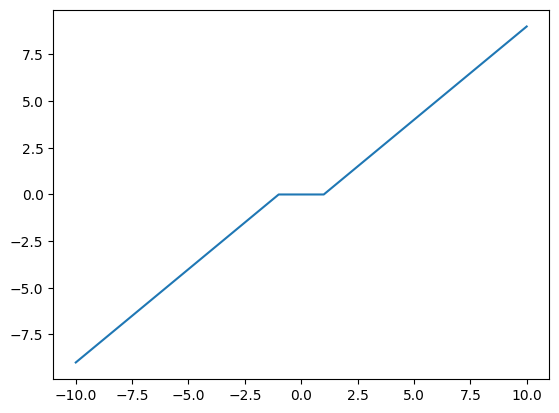

In [25]:
x = np.linspace(-10,10,201)
y = softThreshold1D(x,1)

plt.plot(x,y)

As we can see from the graph, the soft operator shrinks values towards 0. 

Let us now see how we can use this to denoise images. We will pretty much do the same thing as we did before, but this time, using the non linear soft thresholding operator instead of the linear approximation.

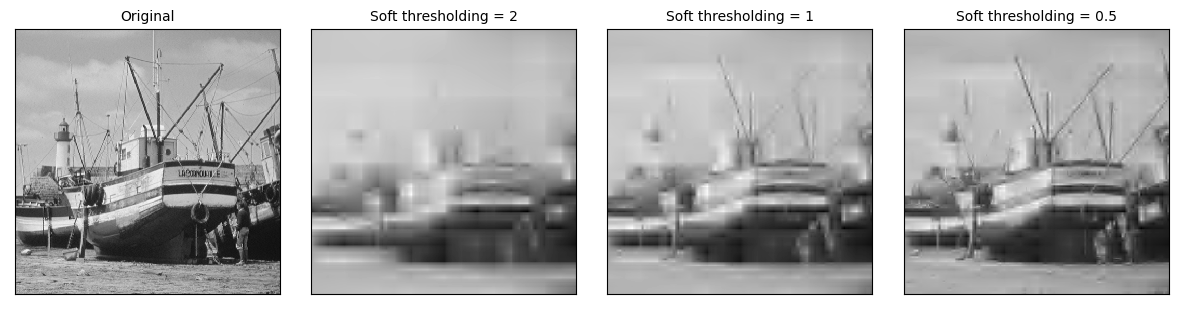

In [26]:
st_boat = softThreshold2DWavelets(wave_boat, 0.02)

thres_vals = [2, 1, 0.5]

titles = ['Original', 'Soft thresholding = '] 
fig = plt.figure(figsize=(12, 3))
ax = fig.add_subplot(1, 4, 1)
ax.imshow(boat_img, interpolation="nearest", cmap=plt.cm.gray)
ax.set_title(titles[0], fontsize=10)
ax.set_xticks([])
ax.set_yticks([])
for i, a in enumerate(ratios):
    ax = fig.add_subplot(1, 4, i + 2)
    ax.imshow(pywt.waverec2(softThreshold2DWavelets(wave_boat, thres_vals[i]), 'db2'), interpolation="nearest", cmap=plt.cm.gray)
    ax.set_title(titles[1]+str(thres_vals[i]), fontsize=10)
    ax.set_xticks([])
    ax.set_yticks([])

fig.tight_layout()
plt.show()

TODO: 

As suggested for the linear approximation, apply the soft thresholding compression on noisy images. 

Record the norm of the error in reconstruction as a function of the noise level. 

In [ ]:
# Your code here

## Wavelet hard thresholding

One can do the same work as for the soft thresholding, but using the hard thresholding. The hard thresholding is different from the soft one in the sense that it does not shrink the actual values, but keep them unchanged, assuming they are larger than the given threshold.

In [27]:
def hardThreshold2DWavelets(in_w_coefs, thres_val): 
    # Your code here 
    denoised_img = in_w_coefs.copy()    
    return denoised_img
        
def hardThreshold2D(in_coefs, thres_val): 
    # Replace here 
    return np.array([arow.copy() for arow in in_coefs])

def hardThreshold1D(in_coefs, thres_val): 
    # Replace here 
    return in_coefs.copy()

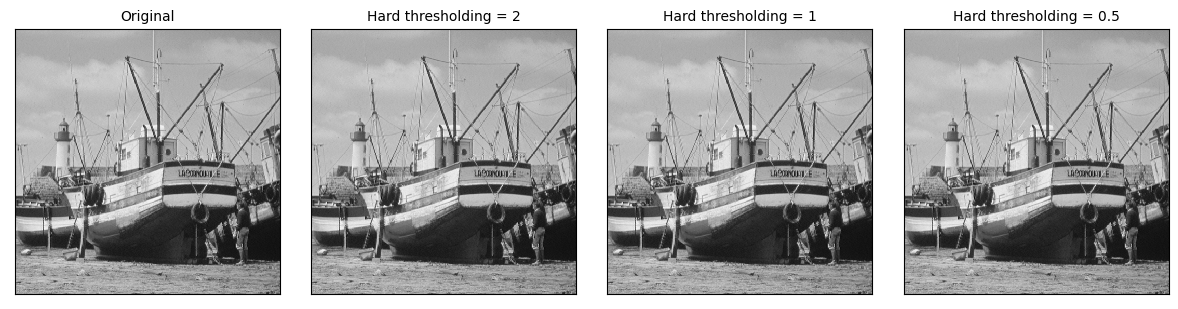

In [28]:
thres_vals = [2, 1, 0.5]

titles = ['Original', 'Hard thresholding = '] 
fig = plt.figure(figsize=(12, 3))
ax = fig.add_subplot(1, 4, 1)
ax.imshow(boat_img, interpolation="nearest", cmap=plt.cm.gray)
ax.set_title(titles[0], fontsize=10)
ax.set_xticks([])
ax.set_yticks([])
for i, a in enumerate(ratios):
    ax = fig.add_subplot(1, 4, i + 2)
    ax.imshow(pywt.waverec2(hardThreshold2DWavelets(wave_boat, thres_vals[i]), 'db2'), interpolation="nearest", cmap=plt.cm.gray)
    ax.set_title(titles[1]+str(thres_vals[i]), fontsize=10)
    ax.set_xticks([])
    ax.set_yticks([])

fig.tight_layout()
plt.show()

In [29]:
sigma1 = 0.1
boat_shape = boat_img.shape
boat_img_n1 = boat_img + sigma1*np.random.randn(boat_shape[0],boat_shape[1])

noisy_wave_boat = pywt.wavedec2(boat_img_n1, wavelet_type, ext_type)

[]

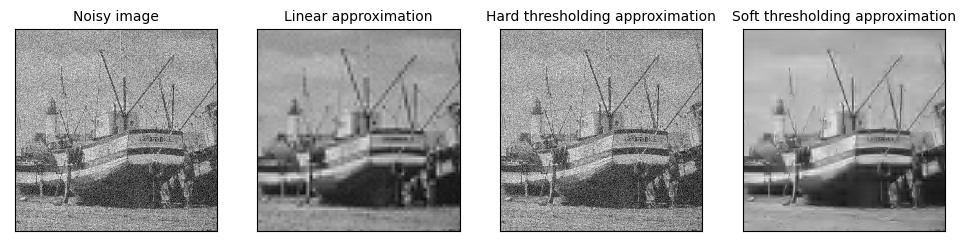

In [30]:
lin_approx_boat = linearApprox(noisy_wave_boat,int(np.size(boat_img)/16))
soft_approx_boat = softThreshold2DWavelets(noisy_wave_boat, sigma1*np.sqrt(2*np.log(2**len(noisy_wave_boat))))
hard_approx_boat = hardThreshold2DWavelets(noisy_wave_boat, 0.45)
titles = ['Original', 'Hard thresholding = '] 
fig = plt.figure(figsize=(12, 3))
ax = fig.add_subplot(1, 4, 1)
ax.imshow(boat_img_n1, interpolation="nearest", cmap=plt.cm.gray)
ax.set_title('Noisy image', fontsize=10)
ax.set_xticks([])
ax.set_yticks([])
ax = fig.add_subplot(1, 4, 2)
ax.imshow(pywt.waverec2(lin_approx_boat,wavelet_type), interpolation="nearest", cmap=plt.cm.gray)
ax.set_title('Linear approximation', fontsize=10)
ax.set_xticks([])
ax.set_yticks([])
ax = fig.add_subplot(1, 4, 3)
ax.imshow(pywt.waverec2(hard_approx_boat,wavelet_type), interpolation="nearest", cmap=plt.cm.gray)
ax.set_title('Hard thresholding approximation', fontsize=10)
ax.set_xticks([])
ax.set_yticks([])
ax = fig.add_subplot(1, 4, 4)
ax.imshow(pywt.waverec2(soft_approx_boat,wavelet_type), interpolation="nearest", cmap=plt.cm.gray)
ax.set_title('Soft thresholding approximation', fontsize=10)
ax.set_xticks([])
ax.set_yticks([])


To go further: 

Change the type of noise, the type of wavelets, the thresholds, the image. 

You may graph the accuracy of the approximation as a function of the threhsold and of the noise value. 